# LinkScribe - Smart Link Organizer
XYZ Startup

---

### Devs (BluePill Intelligence):
- Sebastian Betancourth (2230897)
- Sebastian Rangel (2236475)
- Brayam Saavedra (2230893)


In this project, a Machine Learning model will be trained to classify the content of web pages using NLP techniques.

## Data & Libraries

Particularly, libraries such as numpy, pandas and nltk were used to manipulate and pre-process content in text format, so it could be used for training ML models.

On the other hand, sklearn was mainly used to process the data in training and test sets, and for subsequent training of the model and performance evaluation through metrics such as accuracy, precision, and sensitivity. The evaluation of the model was also carried out visually by applying the confusion matrix.

In [ ]:
!pip install imbalanced-learn

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import nltk
import string
import re
import sklearn.metrics as sm
import imblearn
import joblib
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE,RandomOverSampler
from sklearn.naive_bayes import MultinomialNB

### About the dataset
According to the source of the dataset in [Kaggle](https://www.kaggle.com/datasets/hetulmehta/website-classification), it was created by extracting information from different sites and subsequently classifying the extracted content into multiple categories.

The attributes of the data set consist of:

* website_url: Website URL link.
* cleaned_website_text: The cleaned text content extracted from the website.
* category: Content classification label.

In [ ]:
website_data= pd.read_csv('website_classification.csv')
website_data

,Unnamed: 0,website_url,cleaned_website_text,Category
0,0,https://www.booking.com/index.html?aid=1743217,official site good hotel accommodation big sav...,Travel
1,1,https://travelsites.com/expedia/,expedia hotel book sites like use vacation wor...,Travel
2,2,https://travelsites.com/tripadvisor/,tripadvisor hotel book sites like previously d...,Travel
3,3,https://www.momondo.in/?ispredir=true,cheap flights search compare flights momondo f...,Travel
4,4,https://www.ebookers.com/?AFFCID=EBOOKERS-UK.n...,bot create free account create free account si...,Travel
...,...,...,...,...
1403,1403,http://www.oldwomen.org/,old nude women porn mature granny sex horny ol...,Adult
1404,1404,http://www.webcamslave.com,bdsm cams bdsm chat bondage cams free bdsm vid...,Adult
1405,1405,http://www.buyeuroporn.com/,porno dvd online european porn dvd cheap adult...,Adult
1406,1406,http://www.analdreamhouse.com/30/03/agecheck/i...,anal dream house anal dream house anal dream h...,Adult


Before using the data, it is explored to understand its composition.

First of all, the "website_url" and "Unnamed: 0" columns are eliminated, since they will not be useful.

Subsequently, the sample count by category is displayed. As can be seen, there is a significant imbalance for the "forums" and "adult" categories. This problem will be addressed later using the "imbalanced-learn" library.

In [ ]:
website_url_data= website_data[['website_url','Category']]
website_data.drop(['Unnamed: 0','website_url'],axis=1,inplace=True)

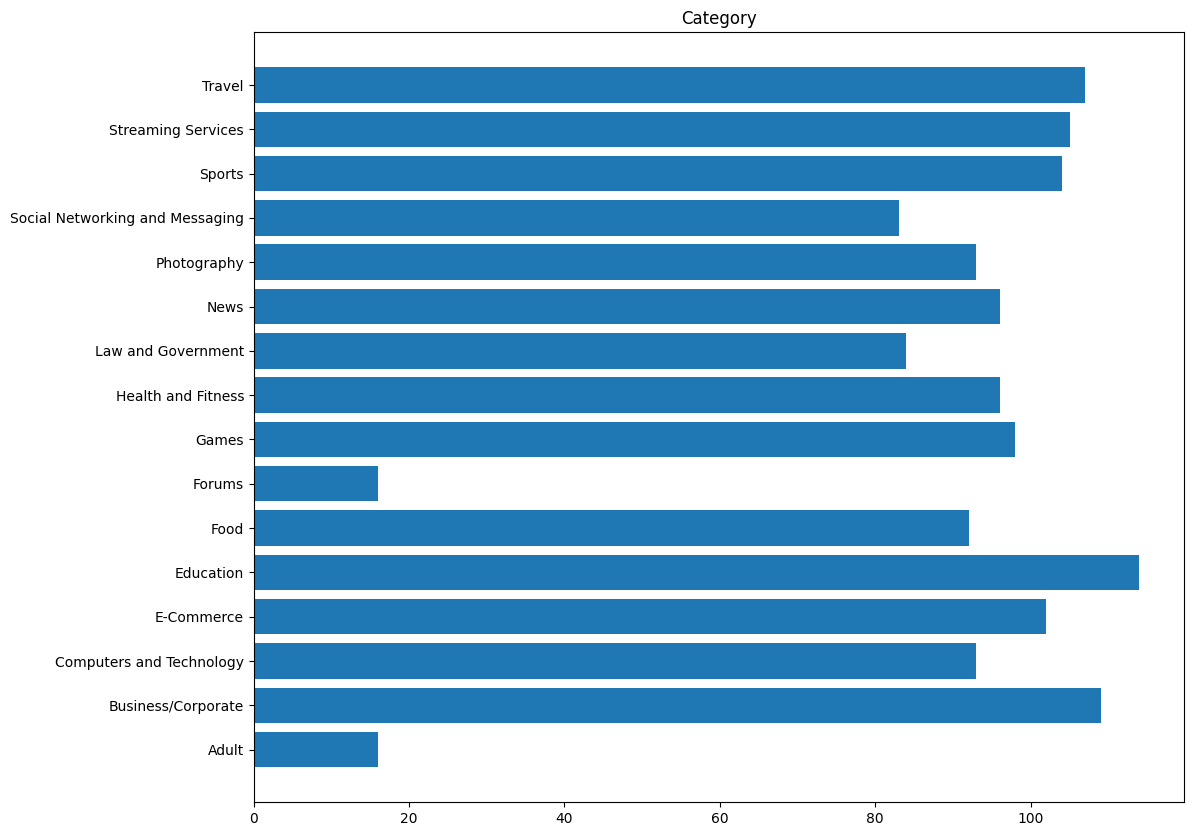

In [ ]:
plt.figure(figsize=(12,10))
plt.title('Category')
website_category= pd.DataFrame(website_data.groupby('Category').size(),columns=['Count'])
plt.barh(width=website_category['Count'],y=website_category.index)
plt.show()

## Data Preprocessing and Cleaning

Data cleaning consisted of adjustments made to the text content so it was ready to be transformed into a format understandable by the ML model.

First, all characters in the text strings were converted to lowercase letters.

In [ ]:
website_data['cleaned_website_text']= website_data['cleaned_website_text'].apply(lambda x:x.lower())

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Word Tokenization

Tokenization consisted of dividing text strings into individual words or tokens, in such a way that the text is broken down into smaller units.

In [ ]:
website_data['tokenized_words'] = website_data['cleaned_website_text'].apply(lambda x:word_tokenize(x))
website_data

,cleaned_website_text,Category,tokenized_words
0,official site good hotel accommodation big sav...,Travel,"[official, site, good, hotel, accommodation, b..."
1,expedia hotel book sites like use vacation wor...,Travel,"[expedia, hotel, book, sites, like, use, vacat..."
2,tripadvisor hotel book sites like previously d...,Travel,"[tripadvisor, hotel, book, sites, like, previo..."
3,cheap flights search compare flights momondo f...,Travel,"[cheap, flights, search, compare, flights, mom..."
4,bot create free account create free account si...,Travel,"[bot, create, free, account, create, free, acc..."
...,...,...,...
1403,old nude women porn mature granny sex horny ol...,Adult,"[old, nude, women, porn, mature, granny, sex, ..."
1404,bdsm cams bdsm chat bondage cams free bdsm vid...,Adult,"[bdsm, cams, bdsm, chat, bondage, cams, free, ..."
1405,porno dvd online european porn dvd cheap adult...,Adult,"[porno, dvd, online, european, porn, dvd, chea..."
1406,anal dream house anal dream house anal dream h...,Adult,"[anal, dream, house, anal, dream, house, anal,..."


Regular expressions are then used to determine whether the tokens have special characters. This is made to remove sources of noise that may result in preserving characters other than letters.

In [ ]:
website_data['tokenized_words'] = website_data['tokenized_words'].apply(lambda x:[re.sub(f'[{string.punctuation}]+','',i) for i in x if i not in list(string.punctuation)])
website_data

,cleaned_website_text,Category,tokenized_words
0,official site good hotel accommodation big sav...,Travel,"[official, site, good, hotel, accommodation, b..."
1,expedia hotel book sites like use vacation wor...,Travel,"[expedia, hotel, book, sites, like, use, vacat..."
2,tripadvisor hotel book sites like previously d...,Travel,"[tripadvisor, hotel, book, sites, like, previo..."
3,cheap flights search compare flights momondo f...,Travel,"[cheap, flights, search, compare, flights, mom..."
4,bot create free account create free account si...,Travel,"[bot, create, free, account, create, free, acc..."
...,...,...,...
1403,old nude women porn mature granny sex horny ol...,Adult,"[old, nude, women, porn, mature, granny, sex, ..."
1404,bdsm cams bdsm chat bondage cams free bdsm vid...,Adult,"[bdsm, cams, bdsm, chat, bondage, cams, free, ..."
1405,porno dvd online european porn dvd cheap adult...,Adult,"[porno, dvd, online, european, porn, dvd, chea..."
1406,anal dream house anal dream house anal dream h...,Adult,"[anal, dream, house, anal, dream, house, anal,..."


The next step was to identify stop words (common words in a language) among the tokens to eliminate them. Normally these words are eliminated because they provide little information to the meaning of a text, helping to reduce noise.

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
website_data['tokenized_words'] = website_data['tokenized_words'].apply(lambda x:[i for i in x if i not in stopwords.words('english')])
website_data

,cleaned_website_text,Category,tokenized_words
0,official site good hotel accommodation big sav...,Travel,"[official, site, good, hotel, accommodation, b..."
1,expedia hotel book sites like use vacation wor...,Travel,"[expedia, hotel, book, sites, like, use, vacat..."
2,tripadvisor hotel book sites like previously d...,Travel,"[tripadvisor, hotel, book, sites, like, previo..."
3,cheap flights search compare flights momondo f...,Travel,"[cheap, flights, search, compare, flights, mom..."
4,bot create free account create free account si...,Travel,"[bot, create, free, account, create, free, acc..."
...,...,...,...
1403,old nude women porn mature granny sex horny ol...,Adult,"[old, nude, women, porn, mature, granny, sex, ..."
1404,bdsm cams bdsm chat bondage cams free bdsm vid...,Adult,"[bdsm, cams, bdsm, chat, bondage, cams, free, ..."
1405,porno dvd online european porn dvd cheap adult...,Adult,"[porno, dvd, online, european, porn, dvd, chea..."
1406,anal dream house anal dream house anal dream h...,Adult,"[anal, dream, house, anal, dream, house, anal,..."


### Word reduction (Normalization)

In this step, a technique known as **Lemmatization** of words was used. This process allows a word to be reduced to its base or root form.
Word lemmatization is useful in NLP for normalizing words as it reduces them for further analysis.

In [ ]:
 nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
wordnetlemmatizer= WordNetLemmatizer()
website_data['tokenized_words']=website_data['tokenized_words'].apply(lambda x:[wordnetlemmatizer.lemmatize(i) for i in x])
website_data

,cleaned_website_text,Category,tokenized_words
0,official site good hotel accommodation big sav...,Travel,"[official, site, good, hotel, accommodation, b..."
1,expedia hotel book sites like use vacation wor...,Travel,"[expedia, hotel, book, site, like, use, vacati..."
2,tripadvisor hotel book sites like previously d...,Travel,"[tripadvisor, hotel, book, site, like, previou..."
3,cheap flights search compare flights momondo f...,Travel,"[cheap, flight, search, compare, flight, momon..."
4,bot create free account create free account si...,Travel,"[bot, create, free, account, create, free, acc..."
...,...,...,...
1403,old nude women porn mature granny sex horny ol...,Adult,"[old, nude, woman, porn, mature, granny, sex, ..."
1404,bdsm cams bdsm chat bondage cams free bdsm vid...,Adult,"[bdsm, cam, bdsm, chat, bondage, cam, free, bd..."
1405,porno dvd online european porn dvd cheap adult...,Adult,"[porno, dvd, online, european, porn, dvd, chea..."
1406,anal dream house anal dream house anal dream h...,Adult,"[anal, dream, house, anal, dream, house, anal,..."


### Text unification

Once the tokens are cleaned and preprocessed, they are joined back into normalized word strings.

In [ ]:
website_data['tokenized_words']= website_data['tokenized_words'].apply(lambda x:' '.join(x))
website_data.drop(['cleaned_website_text'],axis=1,inplace=True)
website_data

,Category,tokenized_words
0,Travel,official site good hotel accommodation big sav...
1,Travel,expedia hotel book site like use vacation work...
2,Travel,tripadvisor hotel book site like previously de...
3,Travel,cheap flight search compare flight momondo fin...
4,Travel,bot create free account create free account si...
...,...,...
1403,Adult,old nude woman porn mature granny sex horny ol...
1404,Adult,bdsm cam bdsm chat bondage cam free bdsm video...
1405,Adult,porno dvd online european porn dvd cheap adult...
1406,Adult,anal dream house anal dream house anal dream h...


## Categories Coding

In this stage, the categories or labels were coded into numerical values, which facilitates their use in the ML algorithm.

In [ ]:
le=LabelEncoder()
website_data['Category_1']= website_data['Category']
website_data['Category']= le.fit_transform(website_data['Category'])

In [ ]:
cat = dict(zip(website_data['Category'].unique().tolist(),website_data['Category_1'].unique().tolist() ))
cat

{15: 'Travel',
 12: 'Social Networking and Messaging',
 10: 'News',
 14: 'Streaming Services',
 13: 'Sports',
 11: 'Photography',
 9: 'Law and Government',
 8: 'Health and Fitness',
 7: 'Games',
 3: 'E-Commerce',
 6: 'Forums',
 5: 'Food',
 4: 'Education',
 2: 'Computers and Technology',
 1: 'Business/Corporate',
 0: 'Adult'}

## Splitting the training and test sets

Once the data set is ready to be used, it is divided into training and test sets. In this case, 70% of the data was taken for training and the remainder for model evaluation.

In [ ]:
X_train,X_test,y_train,y_test= train_test_split(website_data['tokenized_words'], website_data['Category'],test_size=0.3,random_state=0)

## Word vectorization

Prior to training the model, vectorization of the text strings was performed. This process consisted of converting these strings into numerical representations. For this, an implementation of the TF-IDF (Term Frequency-Inverse Document Frequency) method was used, which allows such numerical representation of texts based on the importance of a word in a set of texts. In this case the importance of a word is measured as its frequency within the total set of words.

In [ ]:
tf_idf_vectorizer= TfidfVectorizer()
X_train= tf_idf_vectorizer.fit_transform(X_train)
X_train= pd.DataFrame(X_train.toarray(),columns=tf_idf_vectorizer.get_feature_names_out())

In [ ]:
y_train.value_counts()

14    81
4     77
3     76
13    75
8     75
7     72
15    70
1     69
2     69
12    65
9     62
10    59
5     58
11    54
0     12
6     11
Name: Category, dtype: int64

## Data balancing

Another step prior to training consisted of addressing the problem of data imbalance. Therefore, the increase in the number of samples of the minority classes was carried out using a random oversampling method.

The importance of addressing the problem of data imbalance lies in the tendency of ML models to be biased towards majority classes. Therefore, it was decided to generate new samples for the minority classes with the aim of increasing the performance of the model as a result.

In [ ]:
y_train_counts = y_train.value_counts()
sampling_strategy= y_train_counts.to_dict()
for key, value in sampling_strategy.items():
    if value < 50:
        sampling_strategy[key] = 60
oversample = RandomOverSampler(sampling_strategy=sampling_strategy)
X_train,y_train= oversample.fit_resample(X_train,y_train)

In [ ]:
y_train.value_counts()

14    81
4     77
3     76
13    75
8     75
7     72
15    70
1     69
2     69
12    65
9     62
6     60
0     60
10    59
5     58
11    54
Name: Category, dtype: int64

## Training

As the ML model, the Naive Bayes algorithm was chosen. This algorithm is useful in text classification tasks focused on document categorization where the input features are word counts or frequencies.

In [ ]:
model_clf= MultinomialNB()
model_clf.fit(X_train,y_train)

MultinomialNB()

## Results with test data

### Training and Test Accuracy

As the first performance evaluation measure, the accuracy with the training and test set was used.

In [ ]:
X_test= tf_idf_vectorizer.transform(X_test)
X_test= pd.DataFrame(X_test.toarray(),columns=tf_idf_vectorizer.get_feature_names_out())
y_pred= model_clf.predict(X_test)
print(f'accuracy train {sm.accuracy_score(y_train,model_clf.predict(X_train))}')
print(f'accuracy test {sm.accuracy_score(y_test,y_pred)}')

accuracy train 0.9953789279112755
accuracy test 0.8912529550827423


* In the training set, 99.54% of the samples were predicted, suggesting that the model fits well to the training data and is capable of capturing the patterns of this data.

* Regarding the test set, the model achieved a successful prediction of 89.13%, which indicates that the model is able to generalize new data well.

In relation to this metric, it can be said that in general the model was able to fit the training data and achieved a positive degree of generalization with the test data. Taking into account that the difference in accuracy is not significant between both sets of data, it could be suggested that the model does not present a high degree of overfitting to the training data.

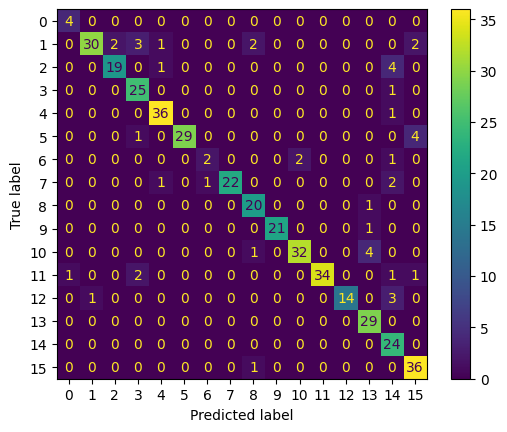

In [ ]:
sm.ConfusionMatrixDisplay.from_estimator(model_clf,X_test,y_test)

In [ ]:
print(sm.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       0.97      0.75      0.85        40
           2       0.90      0.79      0.84        24
           3       0.81      0.96      0.88        26
           4       0.92      0.97      0.95        37
           5       1.00      0.85      0.92        34
           6       0.67      0.40      0.50         5
           7       1.00      0.85      0.92        26
           8       0.83      0.95      0.89        21
           9       1.00      0.95      0.98        22
          10       0.94      0.86      0.90        37
          11       1.00      0.87      0.93        39
          12       1.00      0.78      0.88        18
          13       0.83      1.00      0.91        29
          14       0.65      1.00      0.79        24
          15       0.84      0.97      0.90        37

    accuracy                           0.89       423
   macro avg       0.88   

In general, most categories obtained high precision and sensitivity values. Particularly, the model had problems with the classification of category 6 (Forums), which obtained a precision value of 0.67 and 0.40 sensitivity. The above indicates that for this category the model is somewhat accurate in positive predictions, however, it is not capable of capturing all positive samples.

## Classifier and vectorizer extraction

In [ ]:
!pip install joblib

In [ ]:
joblib.dump(model_clf, "clasificor_web.pkl")
joblib.dump(tf_idf_vectorizer, 'tfidf_vectorizer_model.pkl')

['tfidf_vectorizer_model.pkl']